# 01 - Extracting the data and visualization
***

**Tutorial :** This tutorial provides a step to step guide to extract data from the the Canadian astronomy data centre (CADC) and the open data portal of the Canadian Space Agency. </br>
**Mission and Instrument :** NEOSSAT  
**Astronomical Target :** Detecting and tracking near earth objects      
**System Requirements :** Python 3.9 or later  
**Tutorial Level :** Basic  

For more information on on the NEOSSAT space telescope and the FITS files please consult NEOSSat FITS Image User’s Guide via the following link: https://donnees-data.asc-csa.gc.ca/users/OpenData_DonneesOuvertes/pub/NEOSSAT/Supporting%20Documents/CSA-NEOSSAT-MAN-0002_FITS_IMAGE_UGUIDE-v4-00.pdf

**Extracting data from the open data portal of the Canadian Space Agency (CSA):**: The Canadian Space Agency has a dedicated page to NEOSSAT datasets on its open data and information webapge which can be found via the following link: https://donnees-data.asc-csa.gc.ca/en/dataset/9ae3e718-8b6d-40b7-8aa4-858f00e84b30

**Extracting data from the Canadian Astronomy Data Centre (CADC)**: CADC recoemmnds the installation of CADCdata package for usage in python. Documentation on how to access the library is available with the pydoc cadcdata. For more information visit: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/#library



## Option 1 - Extracting NEOSSAT data from the Canadian Space Agency (CSA)
With the Canadian Space Agency dataset you can filter the NEOSSAT data based on the year, day of year and time.

To understand the structure of data: 

The folders show the Year. The subfolders show the day of year. The .fits files are named accorting to the Year, Day of Year and Hour

Ex: NEOS_SCI_2021002000257.fits => [Year: 2021], [Day of Year: 002], [Time: 00:02:57]

### Importing required libraries

In [1]:
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
import matplotlib.pyplot as plt
from ftplib import FTP
import os
import re
from astropy.coordinates import SkyCoord
import astropy.units as u

The function below will filter through the CSA NEOSSAT data based on the year and the year of year. It will then download the .fits files to the local path. 

In [2]:
def download_fits_files(year, day_of_year, local_directory):
    ftp_host = 'ftp.asc-csa.gc.ca'
    ftp = FTP (ftp_host)
    ftp.login ()

    ftp_directory = f'/users/OpenData_DonneesOuvertes/pub/NEOSSAT/ASTRO/{year}/{day_of_year}/'
    ftp.cwd(ftp_directory)

    # List all .fits files in the directory
    fits_files = [file for file in ftp.nlst() if file.endswith('.fits')]

    for fits_file in fits_files:
        local_filename = os.path.join(local_directory, fits_file)
        with open(local_filename, 'wb') as f:
            ftp.retrbinary('RETR ' + fits_file, f.write)

    ftp.quit()
    print("Download complete.")

Select the year, and the day of year you are interested in. In this example we are downloading the data from Feb 19th, 2024

In [3]:
year = '2024'
day_of_year = '050'
local_directory = 'C:/Users/rsheikholmolouki/Desktop/NEOSSAT_CSA/Part 1/2024/050'
download_fits_files(year, day_of_year, local_directory)

Download complete.


Another way to filter through the data by selecting the time and only download the range of .fits file that matches the time criteria. We start by defining the function: 

In [13]:
def download_fits_files_in_time_range(year, day_of_year, start_time, end_time, local_directory):
    ftp_host = 'ftp.asc-csa.gc.ca'
    ftp = FTP (ftp_host)
    ftp.login ()
    
    ftp_directory = f'/users/OpenData_DonneesOuvertes/pub/NEOSSAT/ASTRO/{year}/{day_of_year}/'
    ftp.cwd(ftp_directory)
    
# List all .fits files in the directory
    fits_files = [file for file in ftp.nlst() if file.endswith('.fits')]

    start_time_str = start_time.zfill(6)
    end_time_str = end_time.zfill(6)

    filtered_files = []
    for fits_file in fits_files:
        match = re.search(r'(\d{6})\.fits$', fits_file)
        if match:
            file_time_str = match.group(1)
            if start_time_str <= file_time_str <= end_time_str:
                filtered_files.append(fits_file)

    if filtered_files:
        for fits_file in filtered_files:
            local_filename = os.path.join(local_directory, fits_file)
            with open(local_filename, 'wb') as f:
                ftp.retrbinary('RETR ' + fits_file, f.write)
        print("Download complete.")
        return filtered_files
    else:
        print("No files found in the specified time range.")
        return None

Select the year, the day of year and the time range you are interested in. In this example we are downloading the data from Feb 19th, 2024 from 00:02:57 to 01:09:20

In [15]:
year = '2024'
day_of_year = '002'
start_time = '000000' #If the time in mind is 00:00:00 write 000000 to match the last 6 digits filename of the .fits file
end_time = '010257' #If the time in mind is 01:09:20 write 010920 to match the last 6 digits filename of the .fits file
local_directory = 'C:/Users/rsheikholmolouki/Desktop/NEOSSAT_CSA/Part 1/2024/time_range'

downloaded_files = download_fits_files_in_time_range(year, day_of_year, start_time, end_time, local_directory)

Download complete.


Let's visualize the selected range of the .fits files. 

Downloaded files: ['NEOS_SCI_2024002000257.fits', 'NEOS_SCI_2024002000557.fits']


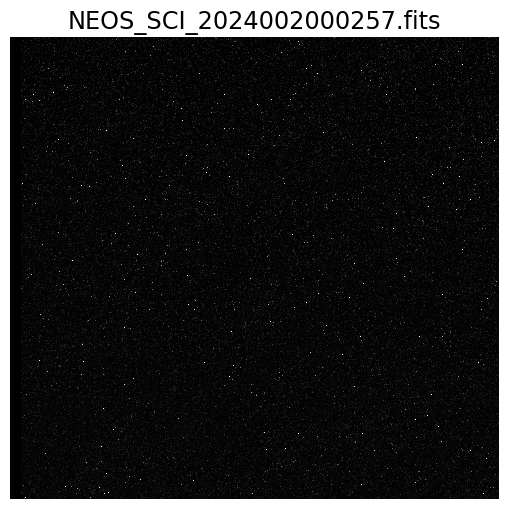

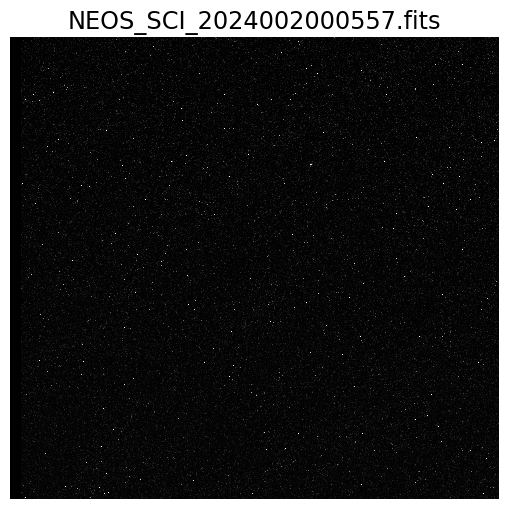

In [28]:
if downloaded_files:
    print("Downloaded files:", downloaded_files)
    # Visualize the .fits files
    from astropy.visualization import astropy_mpl_style
    from astropy.io import fits
    import matplotlib.pyplot as plt

    for fits_file in downloaded_files:
        fits_path = os.path.join(local_directory, fits_file)
        with fits.open(fits_path) as hdul:
            data = hdul[0].data

        plt.imshow(data, cmap='gray', interpolation='nearest') 
        plt.axis('off')  # Turn off axes
        plt.title(fits_file)
        plt.show()

## Option 2 - Extracting NEOSSAT data from the Canadian Astronomy Data Centre (CADC)

With CADC datasets, in addition to filtering the data based on time, you can also filter through NEOSSAT data based on the sky coordinates. 

### Importing required libraries

In [17]:
from astroquery.cadc import Cadc
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [18]:
#Initialize the CADC client 
cadc = Cadc()

#Print information about available collection 
for collection, details in sorted(cadc.get_collections().items()):
   print(f'{collection} : {details}')

APASS : {'Description': 'The APASS collection at the CADC', 'Bands': ['Optical', 'Infrared|Optical', '']}
BLAST : {'Description': 'The BLAST collection at the CADC', 'Bands': ['', 'Millimeter']}
BRITE-Constellation : {'Description': 'The BRITE-Constellation collection at the CADC', 'Bands': ['Optical']}
CFHT : {'Description': 'The CFHT collection at the CADC', 'Bands': ['Infrared|Optical', 'Optical|UV|EUV|X-ray|Gamma-ray', 'Infrared|Optical|UV', '', 'Optical', 'Infrared']}
CFHTMEGAPIPE : {'Description': 'The CFHTMEGAPIPE collection at the CADC', 'Bands': ['', 'Infrared|Optical', 'Optical']}
CFHTTERAPIX : {'Description': 'The CFHTTERAPIX collection at the CADC', 'Bands': ['Infrared|Optical', 'Optical', 'Infrared']}
CFHTWIRWOLF : {'Description': 'The CFHTWIRWOLF collection at the CADC', 'Bands': ['Infrared']}
CGPS : {'Description': 'The CGPS collection at the CADC', 'Bands': ['Infrared', 'Radio', 'Millimeter', '', 'Millimeter|Infrared']}
CHANDRA : {'Description': 'The CHANDRA collection 

In [19]:
#Define the target coordinates and search radius based on your preference
coords = SkyCoord(240, -30, unit = 'deg') #RA, DEC, Unit
radius = 2* u.deg

#Query CADC for data within the specificied region and collection 
results = cadc.query_region(coords,radius, collection = 'NEOSSAT')
print (results)

      observationURI       sequenceNumber ... custom_ctype
                                          ...             
-------------------------- -------------- ... ------------
caom:NEOSSAT/2019361083344             -- ...             
caom:NEOSSAT/2020289131527             -- ...             
caom:NEOSSAT/2020289131527             -- ...             
caom:NEOSSAT/2020289131803             -- ...             
caom:NEOSSAT/2020289132039             -- ...             
caom:NEOSSAT/2020289132039             -- ...             
caom:NEOSSAT/2020289132315             -- ...             
caom:NEOSSAT/2020289132551             -- ...             
caom:NEOSSAT/2020289132827             -- ...             
caom:NEOSSAT/2020289133615             -- ...             
                       ...            ... ...          ...
caom:NEOSSAT/2022023035403             -- ...             
caom:NEOSSAT/2022274204800             -- ...             
caom:NEOSSAT/2020289151642             -- ...           

In [20]:
#Filter the query results to select data with a specifc 'time_exposure'. 
# In this example 'time exposure' greater than 50 is selected

filtered_results = results[results['time_exposure'] > 50.0]

#Access data points from the filtered results 
print(filtered_results['time_exposure'][100])
print(filtered_results['position_dimension_naxis2'][100])
print(filtered_results['position_dimension_naxis1'][100])
print(filtered_results['instrument_keywords'][100])
print(filtered_results['metaRelease'][100])

71.0174
1020
1024
16-FINE_POINT
2022-09-22T17:27:19.000


In [21]:
#Get a list of image URLs based on the filtered results
image_list = cadc.get_image_list(filtered_results, coords, radius)

#Print the number of images int he image_list 
print(len(image_list))

#print the last URL in the image_list 
print(image_list[-1])

#Get the filename of the 100th image from the image_list 
filename = image_list[100]
print(filename)

C:\DevSoftware\Anaconda_2023.07\Lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


261
https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=cadc%3ANEOSSAT%2FNEOS_SCI_2020289131251.fits&POS=CIRCLE+240.0000092207316+-29.999996476692232+2.0
https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=cadc%3ANEOSSAT%2FNEOS_SCI_2022265172719_cord.fits&POS=CIRCLE+240.0000092207316+-29.999996476692232+2.0


Let's visualize the selected .fits file. 

In [22]:
#Read the FITS image data from the file
image_data = fits.getdata(filename, ext =0)

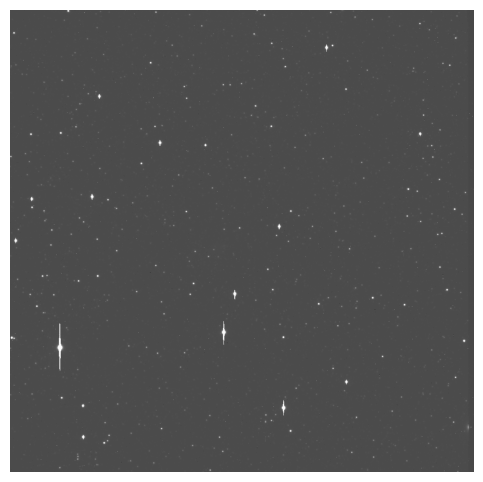

In [23]:
#Show the image file
plt.style.use(astropy_mpl_style)
plt.figure()
plt.axis ('off')
plt.imshow(image_data, cmap='gray')
plt.show()